In [1]:
!pip install git+https://github.com/desi-bgs/bgs-cmxsv.git --upgrade --user

  Cloning https://github.com/desi-bgs/bgs-cmxsv.git to /tmp/pip-req-build-kz8h5iz5
  Running command git clone -q https://github.com/desi-bgs/bgs-cmxsv.git /tmp/pip-req-build-kz8h5iz5
  Created wheel for bgs-sv: filename=bgs_sv-0.0-py3-none-any.whl size=1086170 sha256=0ea1faaa93ff08d363a4ed911d097f4b57723993c05c7bb45793de3e4f4bd80e
  Stored in directory: /tmp/pip-ephem-wheel-cache-setkjcyt/wheels/c5/7b/33/3fa8f7338087a37e7ad7a1378e08d97458e5dbab577a10268f
Successfully built bgs-sv
  Attempting uninstall: bgs-sv
    Found existing installation: bgs-sv 0.0
    Uninstalling bgs-sv-0.0:
      Successfully uninstalled bgs-sv-0.0


In [2]:
import numpy as np 
import scipy as sp
import astropy.table as atable
import astropy.units as u
import matplotlib.pyplot as plt

from bgs_sv import sv1

# Get SV1 exposures during bright time

In [3]:
# read in Aaron's GFA data of exposures through 2021/02/01
gfa = atable.Table.read('/global/cfs/cdirs/desi/users/ameisner/GFA/conditions/offline_matched_coadd_ccds_SV1-thru_20210201.fits')['NIGHT', 'EXPID', 'AIRMASS', 'SKY_MAG_AB', 'MOON_ILLUMINATION', 'MOON_SEP_DEG', 'MOON_ZD_DEG', 'TRANSPARENCY']
exps = gfa.group_by(['EXPID']).groups.aggregate(np.median)

In [4]:
exps[:5]

NIGHT,EXPID,AIRMASS,SKY_MAG_AB,MOON_ILLUMINATION,MOON_SEP_DEG,MOON_ZD_DEG,TRANSPARENCY
float64,int64,float64,float64,float64,float64,float64,float64
20201214.0,67678,1.0245214875180846,20.306343899519227,0.00241368938034363,117.73375330282161,107.18208872228597,0.942125669080867
20201214.0,67679,1.0191465895617893,20.253945455193083,0.0024700775622045036,117.6702245451234,108.53487794245974,0.9043180808706233
20201214.0,67680,1.01446950715555,20.033265558674195,0.002528564919546986,117.60668865736183,109.91266545656522,0.9536320212970133
20201214.0,67681,1.0105723623262,20.218061565792368,0.002586841487755262,117.5431524606984,111.28808981011574,0.9519766636762351
20201214.0,67682,1.0074075191686402,20.202504822354022,0.0026464129287131835,117.47957321208305,112.6723796158372,0.9571964637205332


In [5]:
nominal_dark = 21.07
bright_lim = nominal_dark - 2.5 * np.log10(2.5)

is_bright = (exps['SKY_MAG_AB'] <= bright_lim)
print('%i of %i exposures are during bright time' % (np.sum(is_bright), len(exps)))
bright_exps = exps[is_bright]

269 of 898 exposures are during bright time


# get SV1 bright sky at $\lambda = 5000A$

In [6]:
# get sky surface brightnesses
Iskies = []
for i in np.arange(len(bright_exps)):
    wave, Isky = sv1.get_obs_sky(int(bright_exps[i]['NIGHT']), int(bright_exps[i]['EXPID']), 'model', redux="daily");
    Iskies.append(Isky * 1e17)

20201220-00069032-b: no spectra for model
20201220-00069032-r: no spectra for model
20201220-00069032-z: no spectra for model
20201220-00069082-b: no spectra for model
20201220-00069082-r: no spectra for model
20201220-00069082-z: no spectra for model
20201220-00069083-b: no spectra for model
20201220-00069083-r: no spectra for model
20201220-00069083-z: no spectra for model
20201220-00069084-b: no spectra for model
20201220-00069084-r: no spectra for model
20201220-00069084-z: no spectra for model
20201220-00069085-b: no spectra for model
20201220-00069085-r: no spectra for model
20201220-00069085-z: no spectra for model
20201222-00069363-b: no spectra for model
20201222-00069363-r: no spectra for model
20201222-00069363-z: no spectra for model
20201230-00070056-b: no spectra for model
20201230-00070056-r: no spectra for model
20201230-00070056-z: no spectra for model
20201230-00070057-b: no spectra for model
20201230-00070057-r: no spectra for model
20201230-00070057-z: no spectra fo

In [7]:
# only keep exposures where we have sky data
Iskies = np.array(Iskies)

has_sky = (np.sum(np.array(Iskies), axis=1) > 0.)

bright_exps = bright_exps[has_sky]
Iskies = Iskies[has_sky,:]

In [8]:
# save observing conditions and sky fluxes to file
#bright_exps.write('sv1.bright_exps.20210202.obs_cond.hdf5', format='hdf5')
np.save('sv1.bright_exps.20210202.Isky.npy', Iskies)
np.save('sv1.bright_exps.20210202.wave.npy', wave)

In [9]:
# observing conditions from median value of the GFAs
airmass = bright_exps['AIRMASS']
moon_frac = bright_exps['MOON_ILLUMINATION']
moon_sep = bright_exps['MOON_SEP_DEG']
moon_alt = 90. - bright_exps['MOON_ZD_DEG']
transp = bright_exps['TRANSPARENCY']

[]

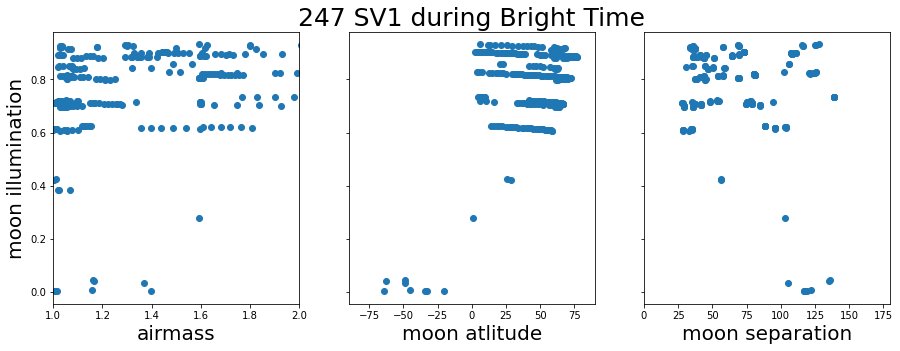

In [10]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(airmass, moon_frac, c='C0')
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(moon_alt, moon_frac, c='C0')
sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])
sub.set_title('%i SV1 during Bright Time' % len(bright_exps), fontsize=25)

sub = fig.add_subplot(133)
sub.scatter(moon_sep, moon_frac, c='C0')
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])

(0.0, 10.0)

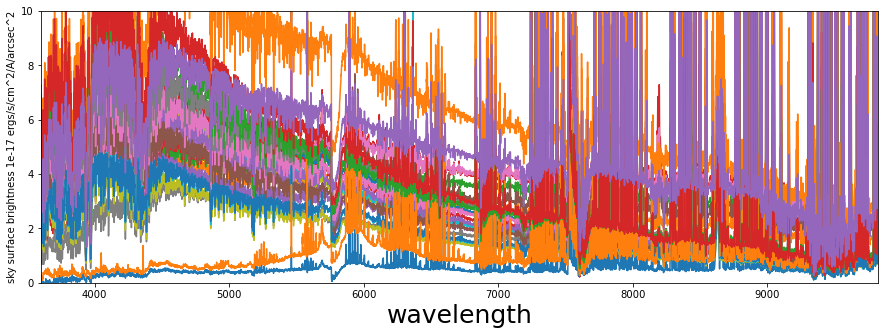

In [11]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
for Isky in Iskies[::10]: 
    sub.plot(wave, Isky)
sub.set_xlabel('wavelength', fontsize=25)
sub.set_xlim(wave.min(), wave.max())
sub.set_ylabel('sky surface brightness 1e-17 ergs/s/cm^2/A/arcsec^2')
sub.set_ylim(0, 10)

In [12]:
from scipy.ndimage import gaussian_filter1d
def smooth_sky(sky, smoothing=100.): 
    return gaussian_filter1d(sky, smoothing) 

(0.0, 10.0)

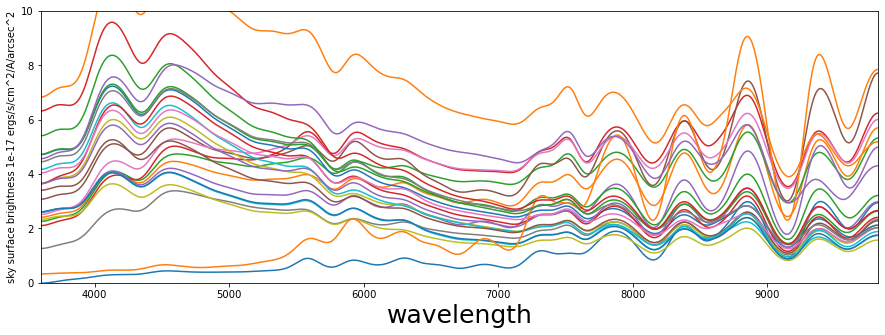

In [13]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
for Isky in Iskies[::10]: 
    sub.plot(wave, smooth_sky(Isky, smoothing=100.))
sub.set_xlabel('wavelength', fontsize=25)
sub.set_xlim(wave.min(), wave.max())
sub.set_ylabel('sky surface brightness 1e-17 ergs/s/cm^2/A/arcsec^2')
sub.set_ylim(0, 10)

In [14]:
Iskies5000 = [] 
for Isky in Iskies: 
    Ismooth = smooth_sky(Isky, smoothing=100.)
    Iskies5000.append(np.interp(5000, wave, Ismooth))

# get sky model predictions at $\lambda = 5000A$
In the BGS survey simulations, I don't use an explicit sky model because exposure time do not scales as the ratio of sky brightness. Instead, I use a linear regression model that predicts the exposure time scaling directly. In order to compare this model to the SV1 sky brightness data, I'm going to convert the exposure factor to sky surface brightness at $5000A$

In [15]:
#https://github.com/changhoonhahn/desisurvey/blob/master/py/desisurvey/etc.py#L279
_notwiCoefficients = np.array([ 0.00000000e+00, -3.25370591e-02,  3.24502646e-01, -7.06229367e-02,
       -4.48817655e-02, -1.08639662e-01,  1.67330251e-01,  1.26047574e-02,
       -2.06369392e-02,  4.27089974e-01, -1.82413474e-02,  8.98795572e-02,
        7.85960945e-04,  9.21368404e-04,  1.34633923e-05,  7.32368512e-02,
       -1.04924141e-01, -1.33399319e-02,  2.74422079e-03,  6.16555294e-01,
        7.95012256e-03, -2.54404656e-02,  1.44795563e-04,  3.74838366e-04,
        4.28923997e-04, -1.07082915e-01, -2.56369357e-02,  7.97087025e-03,
        1.75981316e-04, -4.61519409e-04, -2.50772895e-04, -4.00060046e-06,
       -7.95325622e-06, -6.57333165e-06, -5.42867923e-07])

from itertools import chain, combinations_with_replacement

def BGS_surveysim_bright_exposure_factor(airmass, moon_frac, moon_sep, moon_alt): 
    ''' third degree polynomial regression fit to exposure factor of  
    non-twilight bright sky given airmass and moon_conditions. Exposure factor
    is calculated from the ratio of (sky brightness)/(nominal dark sky
    brightness). The coefficients are fit to DESI CMX and BOSS sky
    surface brightness. See
    https://github.com/changhoonhahn/feasiBGS/blob/97524545ad98df34c934d777f98761c5aea6a4c5/notebook/cmx/exposure_factor_refit.ipynb
    for details. 
    :param airmass: 
        array of airmasses
    :param moon_frac: 
        array of moon illumination fractions
    :param moon_sep: 
        array of moon separations
    :param moon_alt: 
        array of moon altitudes 
    :return fexp: 
        exposure factor for non-twlight bright sky 
    '''
    _notwiIntercept = 3.0493419627360243
    
    theta = np.atleast_2d(np.array([airmass, moon_frac, moon_sep, moon_alt]).T)

    combs = chain.from_iterable(combinations_with_replacement(range(4), i) for i in range(0, 4))

    theta_transform = np.empty((theta.shape[0], len(_notwiCoefficients)))
    for i, comb in enumerate(combs):
        theta_transform[:, i] = theta[:, comb].prod(1)

    fexp = np.dot(theta_transform, _notwiCoefficients.T) + _notwiIntercept
    return fexp

In [16]:
import desisim.simexp
import specsim.instrument
from desimodel.io import load_throughput

# get nominal dark sky surface brightness
wavemin = load_throughput('b').wavemin - 10.0
wavemax = load_throughput('z').wavemax + 10.0
_wave = np.arange(round(wavemin, 1), wavemax, 0.8) * u.Angstrom
config = desisim.simexp._specsim_config_for_wave(_wave.to(u.Angstrom).value, dwave_out=0.8, specsim_config_file='desi')

sb_dict     = config.load_table(config.atmosphere.sky, 'surface_brightness', as_dict=True)
Isky_dark   = sb_dict['dark'] # nominal dark sky

# get fiber area
instrument = specsim.instrument.initialize(config, True)

plate_scale = config.load_table(config.instrument.plate_scale, ['radius', 'radial_scale', 'azimuthal_scale'], interpolate=False)
radial_fiber_size = (0.5 * instrument.fiber_diameter / instrument.radial_scale(plate_scale['radius']))
azimuthal_fiber_size = (0.5 * instrument.fiber_diameter / instrument.azimuthal_scale(plate_scale['radius']))

desi_fiber_area = np.mean(np.pi*radial_fiber_size * azimuthal_fiber_size)

# only going to use b spectrograph since we're only using the sky at 5000A 
camera = instrument.cameras[0] 
         
# for the nominal dark time expsoure calculate the sky electrons
# and read noise electrons. Note I used 200s nominal exposure time
# to calculate the exposure factors in https://github.com/desi-bgs/feasiBGS/blob/master/notebook/cmx/exposure_factor_refit.ipynb
nom_sky_fibflux = Isky_dark * desi_fiber_area    
nom_sky_photon = nom_sky_fibflux.to(u.erg/u.Angstrom/u.s/u.cm**2) * instrument.photons_per_bin * (200. * u.s)
nom_sky_electron = camera.downsample(camera.apply_resolution(nom_sky_photon * camera.throughput))    

# calculate the read noise term for the nominal dark time exposure, which is nonnegligible
read_noise_electron = camera.downsample(camera.read_noise_per_bin.to(u.electron).value)
rn_term = read_noise_electron**2

# calculate at sky electron and rn term at 5000A
nom_sky_electron_5000 = np.interp(5000., camera.output_wavelength.value, nom_sky_electron)
rn_5000 = np.interp(5000., camera.output_wavelength.value, rn_term)

In [17]:
def convert_exposure_factor_to_sky_sb5000(fsky): 
    ''' convert exposure factor from BGS_surveysim_exposure_factor to sky
    surface brightness at 5000A
    '''
    # get sky electron give the exposure factor
    a = 2. * fsky * (nom_sky_electron_5000 + rn_5000)
    b = 4. * rn_5000 * (nom_sky_electron_5000 + rn_5000)
    sky_electron = (a**2 - b)/(2. * a)
    #print(fsky, nom_sky_electron_5000, sky_electron)

    # convert to photons crudely with interp
    sky_photon = sky_electron / np.interp(5000., _wave.value, camera.throughput)
    # convert to fiberflux
    sky_fibflux = sky_photon / np.interp(5000., _wave.value, instrument.photons_per_bin) / (200. * u.s)
    # convert to sky surface brightness
    sky_sb = sky_fibflux / desi_fiber_area
    return sky_sb.value * 1e17

In [18]:
Iskies5000_BGS_surveysim = []
for i in range(len(bright_exps)): 
    _f_exp_i = BGS_surveysim_bright_exposure_factor(airmass[i], moon_frac[i], moon_sep[i], moon_alt[i])
    Iskies5000_BGS_surveysim.append(convert_exposure_factor_to_sky_sb5000(_f_exp_i))
Iskies5000_BGS_surveysim = np.concatenate(Iskies5000_BGS_surveysim)

Text(0, 0.5, '$I_{\\rm sky}[5000A]$ predicted by BGS surveysim')

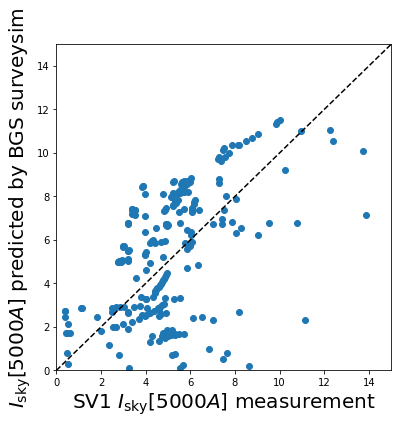

In [19]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.scatter(Iskies5000, Iskies5000_BGS_surveysim)
sub.plot([0., 15.], [0., 15.], c='k', ls='--')
sub.set_xlim(0., 15)
sub.set_xlabel(r'SV1 $I_{\rm sky}[5000A]$ measurement', fontsize=20)
sub.set_ylim(0., 15)
sub.set_ylabel(r'$I_{\rm sky}[5000A]$ predicted by BGS surveysim', fontsize=20)

# TRANSP > 0.9 and MOON ALT > 0
Lets focus the comparison to exposures with reasonable transparencies (i.e. days without clouds)

Text(0.5, 1.0, 'TRANSP > 0.9, MOON ALT > 0')

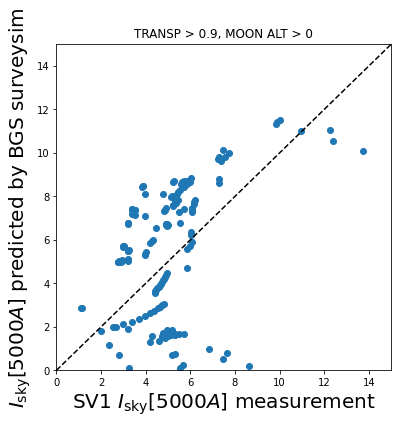

In [20]:
transp_cut = (transp > 0.9) & (moon_alt > 0.)

fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.scatter(np.array(Iskies5000)[transp_cut], Iskies5000_BGS_surveysim[transp_cut])
sub.plot([0., 15.], [0., 15.], c='k', ls='--')
sub.set_xlim(0., 15)
sub.set_xlabel(r'SV1 $I_{\rm sky}[5000A]$ measurement', fontsize=20)
sub.set_ylim(0., 15)
sub.set_ylabel(r'$I_{\rm sky}[5000A]$ predicted by BGS surveysim', fontsize=20)
sub.set_title("TRANSP > 0.9, MOON ALT > 0")

What's going on with the exposures where the surveysim model predicts fainter skies?

[]

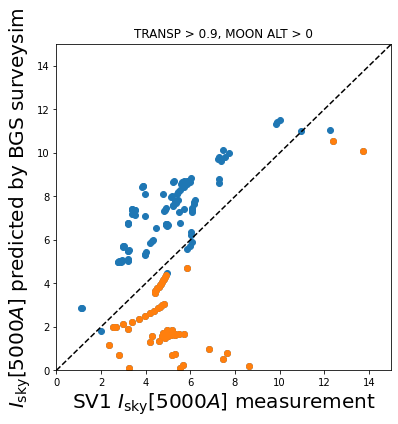

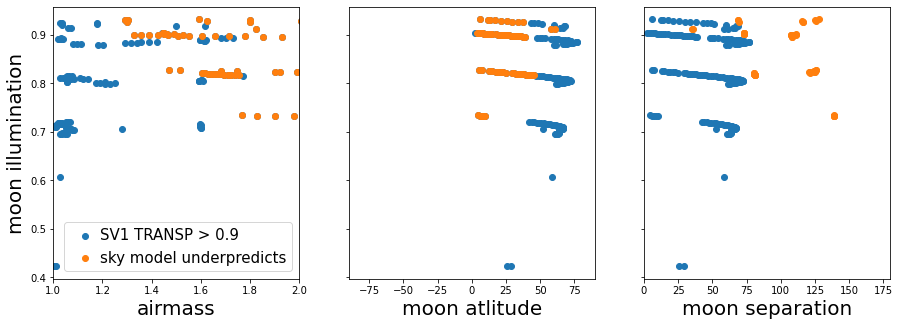

In [21]:
fainter = (np.array(Iskies5000_BGS_surveysim)/np.array(Iskies5000) < 0.9) 

fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.scatter(np.array(Iskies5000)[transp_cut], np.array(Iskies5000_BGS_surveysim)[transp_cut])
sub.scatter(np.array(Iskies5000)[transp_cut & fainter], np.array(Iskies5000_BGS_surveysim)[transp_cut & fainter])
sub.plot([0., 15.], [0., 15.], c='k', ls='--')
sub.set_xlim(0., 15)
sub.set_xlabel(r'SV1 $I_{\rm sky}[5000A]$ measurement', fontsize=20)
sub.set_ylim(0., 15)
sub.set_ylabel(r'$I_{\rm sky}[5000A]$ predicted by BGS surveysim', fontsize=20)
sub.set_title("TRANSP > 0.9, MOON ALT > 0")

fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(airmass[transp_cut], moon_frac[transp_cut], c='C0', label='SV1 TRANSP > 0.9')
sub.scatter(airmass[transp_cut & fainter], moon_frac[transp_cut & fainter], c='C1', label='sky model underpredicts')
sub.legend(loc='lower right', frameon=True, handletextpad=0, fontsize=15)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(moon_alt[transp_cut], moon_frac[transp_cut], c='C0')
sub.scatter(moon_alt[transp_cut & fainter], moon_frac[transp_cut & fainter], c='C1')
sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sub.scatter(moon_alt[transp_cut], moon_frac[transp_cut], c='C0')
sub.scatter(moon_sep[transp_cut & fainter], moon_frac[transp_cut & fainter], c='C1')
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])

# new exposure factor model fit w/ SV1 data

In [22]:
#https://github.com/changhoonhahn/desisurvey/blob/master/py/desisurvey/etc.py#L279
sv1_notwiCoefficients = np.array([ 0.00000000e+00, -9.58679635e-02,  5.93841512e-01, -2.55861615e-02,
 -4.41591474e-02, -7.79678593e-01,  3.85818939e-01,  7.79679323e-03,
  5.59921835e-02,  6.11104223e-02, -1.31110611e-02, -8.79745360e-03,
  2.46048016e-04,  1.67042274e-04,  2.94236583e-04,  6.18672422e-01,
  2.44202035e-01, -2.48791060e-02, -3.85417472e-02,  8.30483197e-02,
 -5.63610422e-03,  4.40148404e-02,  4.27190211e-04,  4.97703948e-04,
  1.20209680e-04,  1.93038858e-02, -1.68032918e-03,  2.47257673e-02,
  1.10776356e-04, -6.39467548e-04, -5.09258980e-04, -3.31065269e-06,
 -3.72136838e-06, -2.85115773e-06, -1.59214888e-06])

def BGS_surveysim_bright_exposure_factor_sv1(airmass, moon_frac, moon_sep, moon_alt): 
    ''' third degree polynomial regression fit to exposure factor of  
    non-twilight bright sky given airmass and moon_conditions. Exposure factor
    is calculated from the ratio of (sky brightness)/(nominal dark sky
    brightness). The coefficients are fit to DESI CMX and BOSS sky
    surface brightness. See
    https://github.com/changhoonhahn/feasiBGS/blob/97524545ad98df34c934d777f98761c5aea6a4c5/notebook/cmx/exposure_factor_refit.ipynb
    for details. 
    :param airmass: 
        array of airmasses
    :param moon_frac: 
        array of moon illumination fractions
    :param moon_sep: 
        array of moon separations
    :param moon_alt: 
        array of moon altitudes 
    :return fexp: 
        exposure factor for non-twlight bright sky 
    '''
    sv1_notwiIntercept = 2.1185346942680368
    
    theta = np.atleast_2d(np.array([airmass, moon_frac, moon_sep, moon_alt]).T)

    combs = chain.from_iterable(combinations_with_replacement(range(4), i) for i in range(0, 4))

    theta_transform = np.empty((theta.shape[0], len(sv1_notwiCoefficients)))
    for i, comb in enumerate(combs):
        theta_transform[:, i] = theta[:, comb].prod(1)

    fexp = np.dot(theta_transform, sv1_notwiCoefficients.T) + sv1_notwiIntercept
    return fexp

In [23]:
Iskies5000_BGS_surveysim_sv1 = []
for i in range(len(bright_exps)): 
    _f_exp_i = BGS_surveysim_bright_exposure_factor_sv1(airmass[i], moon_frac[i], moon_sep[i], moon_alt[i])
    Iskies5000_BGS_surveysim_sv1.append(convert_exposure_factor_to_sky_sb5000(_f_exp_i))
Iskies5000_BGS_surveysim_sv1 = np.concatenate(Iskies5000_BGS_surveysim_sv1)

Text(0.5, 1.0, 'TRANSP > 0.9, MOON ALT > 0')

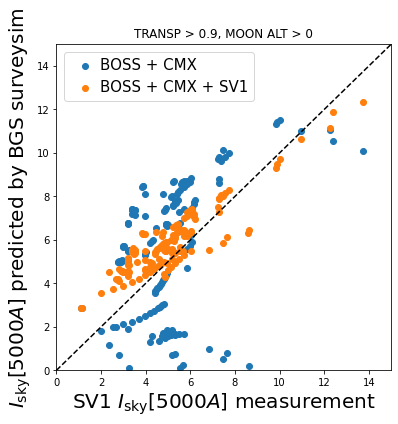

In [29]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.scatter(np.array(Iskies5000)[transp_cut], Iskies5000_BGS_surveysim[transp_cut], label='BOSS + CMX')
sub.scatter(np.array(Iskies5000)[transp_cut], Iskies5000_BGS_surveysim_sv1[transp_cut], label='BOSS + CMX + SV1')
sub.legend(loc='upper left', handletextpad=0, fontsize=15)
sub.plot([0., 15.], [0., 15.], c='k', ls='--')
sub.set_xlim(0., 15)
sub.set_xlabel(r'SV1 $I_{\rm sky}[5000A]$ measurement', fontsize=20)
sub.set_ylim(0., 15)
sub.set_ylabel(r'$I_{\rm sky}[5000A]$ predicted by BGS surveysim', fontsize=20)
sub.set_title("TRANSP > 0.9, MOON ALT > 0")